## The Money Customer Model - TCN
---

In [1]:
# pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple -r requirements.txt --use-deprecated=legacy-resolver
# pip install s3fs
# pip install sidetable

In [2]:
import sys, os, json
import torch
import pandas as pd
import numpy as np
import rdsutils.datagen as datagen
import sidetable

# sys.path.insert(1, "/home/ec2-user/SageMaker/projects-framework/sequential-models/TCN_v2")
# sys.path.insert(1, "../..")

%load_ext autoreload
%autoreload 2

In [3]:
with open("../../config-transactional.json", "r") as f:
    config_trnx = json.load(f)
    
with open("../../config.json", "r") as f:
    config = json.load(f)

In [4]:
trnx_path = "../../data-transactional/features/features_1624300759.feather"
stnry_path = "../../data/combined_all_features/combined_1624302456.feather"

In [5]:
modeling_df_trans = pd.read_feather(trnx_path)
modeling_df_acct = pd.read_feather(stnry_path)

#### data size

In [6]:
modeling_df_trans.shape, modeling_df_acct.shape

((32224682, 122), (11512325, 91))

In [7]:
modeling_df_acct.business_account_number.value_counts().value_counts().sort_index().tail()

44    14
45    14
46    42
47    23
48    61
Name: business_account_number, dtype: int64

In [8]:
modeling_df_trans.business_account_number.value_counts().value_counts().sort_index().tail()

5434    1
5594    1
6098    1
6799    1
7007    1
Name: business_account_number, dtype: int64

In [10]:
modeling_df_trans["hr_of_transaction"] = modeling_df_trans.transaction_datetime.dt.hour
modeling_df_trans["has_transaction_comment"] = ~modeling_df_trans["transaction_comment"].isna()
modeling_df_trans["card_present_ind"] = modeling_df_trans["card_present_ind"].astype(float)

In [11]:
%%time 
modeling_df_trans.sort_values(["transaction_datetime", "business_account_number"],
                              inplace=True)
modeling_df_acct.sort_values(["sample_date", "business_account_number"],
                             inplace=True)
modeling_df_trans = pd.merge_asof(modeling_df_trans, 
                                  modeling_df_acct[["target", 
                                                    "sample_date", 
                                                    "business_account_number"]],
                                  left_on="transaction_datetime",
                                  right_on="sample_date",
                                  by="business_account_number",
                                  direction="forward",
                                  suffixes=("", "_dup"))
modeling_df_trans[["business_account_number", "transaction_datetime", "sample_date"]].head()

CPU times: user 3min 35s, sys: 1min 44s, total: 5min 19s
Wall time: 5min 18s


,business_account_number,transaction_datetime,sample_date
0,410000007044,2017-12-13 16:26:35,2019-02-09 12:03:02
1,410000007044,2017-12-19 23:55:21,2019-02-09 12:03:02
2,410000007044,2017-12-19 23:55:21,2019-02-09 12:03:02
3,410000007044,2017-12-19 23:55:21,2019-02-09 12:03:02
4,410000007044,2017-12-19 23:55:21,2019-02-09 12:03:02


<AxesSubplot:>

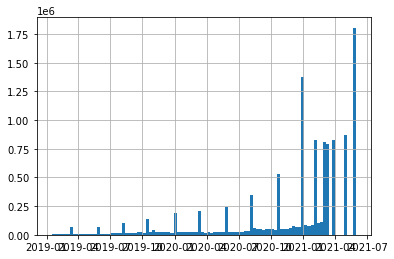

In [12]:
modeling_df_acct.sample_date.hist(bins=100)

### Process and sent to s3

In [13]:
start = pd.to_datetime(config["date_sample_start"])
end = pd.to_datetime(config["date_sample_end"])

In [14]:
train_static = modeling_df_acct[modeling_df_acct.sample_date.between(start, end)]
train_dynamic = modeling_df_trans[modeling_df_trans.transaction_datetime.between(start, end)]

In [16]:
test_static = modeling_df_acct[(modeling_df_acct.sample_date > end) & (modeling_df_acct.is_static)]
test_dynamic = modeling_df_trans

In [17]:
train_dynamic.shape, test_static.shape

((19606777, 126), (6456260, 91))

In [18]:
from utils import preprocess, features

import warnings
warnings.filterwarnings("ignore")

In [41]:
static_features = features
dynamic_features = ['nr_past_transactions', 'card_present_ind', 
                'hr_of_transaction', 'transaction_code',
                'transaction_as_pct_of_balance', 'transaction_amount']
stnry_features = ['all7120', 'vantage_score', 'mtf5820', 'fico_score', 'fraud_score_1', 
                  'iln5520', 'bcc7120', 'phone_risk_score', 'email_risk_score', 'address_risk_score', 
                  'stu5031', 'bcx3423', 'fraud_score_2', 'iqt9415']
target_col=['target']
meta_cols=['borrower_id', 'sample_date', 'transaction_datetime', 'business_account_number']

static_cols = static_features + target_col + meta_cols + ["indeterminate"]
dynamic_cols = dynamic_features + stnry_features + target_col + meta_cols

In [20]:
%%time
train_static = preprocess(train_static)
train_dynamic = preprocess(train_dynamic)

test_static = preprocess(test_static)
test_dynamic = preprocess(test_dynamic)

CPU times: user 1min 7s, sys: 39.2 s, total: 1min 46s
Wall time: 1min 43s


In [42]:
train_static[static_cols].head()

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,target,borrower_id,sample_date,transaction_datetime,business_account_number,indeterminate
1966359,10.0,NaN,NaN,0.0179,NaN,0.9999,0.098912,11.110,0.0000,0.1596,...,316,0,-1.0,-1.0,False,5134631.0,2019-01-16,2019-01-16,410000075041,False
1085775,500.0,NaN,NaN,0.0071,NaN,0.9992,0.026787,479.280,0.0000,0.9916,...,153,0,-1.0,-1.0,False,3070002.0,2019-01-16,2019-01-16,410000132492,False
2197095,12.0,NaN,NaN,0.0143,NaN,0.9994,750.000000,1.000,0.0193,0.4305,...,124,0,-1.0,-1.0,False,4442475.0,2019-01-16,2019-01-16,410000189170,False
1080918,2000.0,NaN,NaN,0.0077,NaN,0.9999,0.000453,2205.930,0.0000,0.6341,...,124,0,-1.0,-1.0,False,4261518.0,2019-01-16,2019-01-16,410000189524,False
305397,250.0,NaN,NaN,0.0190,NaN,0.9999,-0.049856,1582.616,0.0000,0.9737,...,111,0,-1.0,-1.0,False,6181442.0,2019-01-16,2019-01-16,410000208665,False


In [43]:
train_dynamic[dynamic_cols].head()

,nr_past_transactions,card_present_ind,hr_of_transaction,transaction_code,transaction_as_pct_of_balance,transaction_amount,all7120,vantage_score,mtf5820,fico_score,...,address_risk_score,stu5031,bcx3423,fraud_score_2,iqt9415,target,borrower_id,sample_date,transaction_datetime,business_account_number
390349,482,0.0,0,DWMBR,-0.000224,-25.0,NaN,NaN,NaN,NaN,...,0.0013,NaN,NaN,NaN,NaN,False,4294603,2019-02-12 00:00:00,2019-01-16,410000072255
390350,483,0.0,0,DWMBR,-0.000224,-25.0,NaN,NaN,NaN,NaN,...,0.0013,NaN,NaN,NaN,NaN,False,4294603,2019-02-12 00:00:00,2019-01-16,410000072255
390351,709,0.0,0,DWMBR,-0.111375,-15.0,NaN,NaN,NaN,NaN,...,0.0008,NaN,NaN,NaN,NaN,False,4329485,2019-01-22 05:56:55,2019-01-16,410000073178
390352,124,0.0,0,DWBILLPAY,-0.074307,-500.0,NaN,NaN,NaN,NaN,...,0.0008,NaN,NaN,NaN,NaN,False,3960586,2019-02-15 00:00:00,2019-01-16,410000073225
390353,254,0.0,0,ACHDWP2P,-0.019542,-100.0,NaN,NaN,NaN,NaN,...,0.0010,NaN,NaN,NaN,NaN,False,2214308,2019-02-19 00:00:00,2019-01-16,410000074564


### Upload

In [44]:
# save to: s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/data/with-tcn/
s3_path = "s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/data/with-tcn/"

#### Upload full

In [49]:
%%time
train_static[static_cols].to_parquet(os.path.join(s3_path, "train_static.parquet"))
train_dynamic[dynamic_cols].to_parquet(os.path.join(s3_path, "train_dynamic.parquet"))

test_static[static_cols].to_parquet(os.path.join(s3_path, "test_static.parquet"))
test_dynamic[dynamic_cols].to_parquet(os.path.join(s3_path, "test_dynamic.parquet"))

CPU times: user 1min 15s, sys: 8.78 s, total: 1min 24s
Wall time: 3min 18s


#### Upload debug

In [45]:
cols = [set(train_static.business_account_number.unique()),
        set(train_dynamic.business_account_number.unique()),
        set(test_static.business_account_number.unique()),
        set(test_dynamic.business_account_number.unique())]

c = cols[0]
for c_ in cols:
    c = c.intersection(c_)

In [46]:
modeling_df_acct.business_account_number.value_counts().sort_values().tail(20)

410000115263    48
410000616234    48
410000254997    48
410007115890    48
410000746260    48
410000395706    48
410000184082    48
410000450577    48
410000413962    48
410000104174    48
410000528289    48
410000435498    48
410000597407    48
410000488874    48
410000155352    48
410000383305    48
410000595320    48
410001055161    48
410000770007    48
410000420561    48
Name: business_account_number, dtype: int64

In [47]:
df_ = modeling_df_acct
df_ = df_[df_.target]
pos_ids = list(df_.business_account_number.value_counts().sort_values().tail(20).index)

df_ = modeling_df_acct
df_ = df_[~df_.target]
neg_ids = list(df_.business_account_number.value_counts().sort_values().tail(20).index)

debug_ids = pos_ids + neg_ids

In [48]:
%%time
train_static[train_static.business_account_number.isin(debug_ids)][static_cols].to_parquet(os.path.join(s3_path, "debug_train_static.parquet"))
train_dynamic[train_dynamic.business_account_number.isin(debug_ids)][dynamic_cols].to_parquet(os.path.join(s3_path, "debug_train_dynamic.parquet"))

test_static[test_static.business_account_number.isin(debug_ids)][static_cols].to_parquet(os.path.join(s3_path, "debug_test_static.parquet"))
test_dynamic[test_dynamic.business_account_number.isin(debug_ids)][dynamic_cols].to_parquet(os.path.join(s3_path, "debug_test_dynamic.parquet"))

CPU times: user 2.31 s, sys: 10.1 ms, total: 2.32 s
Wall time: 2.96 s
